# Autocorrelation of Eye Tracking Data
This notebook calculates the autocorrelation of raw eye tracking data. 

Objectives:
* Autocorrelation plot showing time points with especially high correlation within the time series of data

## Configuration

In [1]:
# General configuration
import os

# data_directory: str
#     Path to a directory to store data.
data_directory = '.'

# install_missing_packages: bool
#     A flag indicating if missing packages should be automatically installed
install_missing_packages = True

# use_conda: bool
#     A flag indicating if conda should be used for software installation.
#     If False, pip will be used. The default is to use conda if jupyter
#     is run in a conda environment.
use_conda = 'CONDA_EXE' in os.environ

### Check for missing packages

In [2]:
import importlib

def check_package(package, pip_pkg: str = None, conda_pkg: str = None):
    """Check if a given package is installed. If missing install
    it (if global flag `install_missing_packages` is True) either with
    pip or with conda (depending on `use_conda`).
    """
    if importlib.util.find_spec(package) is not None:
        return  # ok, package is already installed

    if not install_missing_packages:
        raise RuntimeError(f"{package} is not installed!")

    if use_conda:
        import conda.cli
        conda.cli.main('conda', 'install',  '-y', conda_pkg or package)
    else:
        import subprocess
        import sys            
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pip_pkg or package])
        
# This is to exit cells without error tracebacks (cosmetic purpose)
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

## Requirements

To run all of this notebook, you need the following libraries to be installed:
* ImageIO (`imageio` and `imageio-ffmpeg`): for reading images and accessing the webcam
* Scikit-image (`scikit-image`) for some image manipulation
* MatPlotLib (`matplotlib`): mainly for displaying images in the notebook
* Dlib (`dlib`) providing the HOG face detector
* OpenCV (`opencv`) for real time applications
* Imutils (`imutils`) for image manipulation with OpenCV

Running the following cell will create a file `graphs.yml` that can be used to setup a conda environment containing the required packages. If you already downloaded the file from my GitHub, skip the next cell and create the env directly from it.


In [ ]:
%%writefile graphs.yml
name: graphs
channels:
  - conda-forge
  - defaults
dependencies:
  - python=3.6
  - jupyter
  - imageio
  - imageio-ffmpeg
  - matplotlib
  - scikit-image
  - opencv
  - networkx
  - pandas
  - statsmodels

### Environment Creation

To create the environment, open the. terminal, go to the directory where you stored the graphs.yml file (the directory of the notebook) and type
```sh
conda env create -f graphs.yml
```
After running this command you have to activate the environment (Linux/MacOS: `conda activate graphs`, Windows: `activate graphs`) and then reopen the notebook in that environment.

# Main part
### Imports and directory definition
The data directory is adjusted to the folder arrangedment of the github repo. Adjust if necessary.

In [3]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nX
import glob
import scipy.cluster.vq as clusters
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.preprocessing import normalize
from pandas.plotting import autocorrelation_plot as AC_plot 
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import acf
from skimage.filters import gaussian
from mpl_toolkits.mplot3d import Axes3D 


OG_DATA_PATH = './'
DATA_PATH = './EyesOnScreen/'
PROCESSED_DATA_PATH = './Results/Autocorrelation/'

## Autocorrelation Part

### Loading
* Loading in the EyesOnScreen data (the ET based hit coordinates on the HMD screen) consisting of X and Y coordinates.

### Calculation
* Using the statsmodels acf autocorrelation function to calculate the autocorrelation for every time shift of the coordinate series (for each coordinate separately).
* I save these into a table.
* Afterwards, using the 10 second mark, calculating a measure of variance for all following extrema

### Plotting
* Plotting the autocorrelation plot of each coordinate separately

### Saving
* Saving the plot and autocorrelation table. 

In [ ]:
# Initialisation 
# If you want to plot
plotting_wanted = False 
# if you want to close the plots immediately 
# careful: notebook could get very long - if you want to see single subs, go to the cell below
close_plots_immediately = True  
# if you want to save the plots
saving_wanted = False 

# data in local folder 
subjectdata = glob.glob(DATA_PATH + '/*.txt')

# initialising dataframe 
autocorr_data = pd.DataFrame()

# loading the subject data going through the local folder
for sub in subjectdata:
    # get the subject ID from data name 
    subID = sub.partition('VP')[2][0:4]
    # read the file and get rid of the brackets
    data = pd.read_csv(sub, names=['X','Y']) 
    data['X'] =  data['X'].apply(lambda x: x.replace('(','').replace(')','')) 
    data['X'] = data['X'].astype('float')
    data['Y'] =  data['Y'].apply(lambda x: x.replace('(','').replace(')','')) 
    data['Y'] = data['Y'].astype('float')
    data_OG_size = data.shape[0]
    
    # only take coordinates in the interval [0,1[ (thereby also removing 0 entries)
    data = data[(data.X>0) & (data.X<=1)]
    data = data[(data.Y>0) & (data.Y<=1)]
    data_processed_size = data.shape[0]
    
    removedr = data_OG_size - data_processed_size
    proportion = removedr/data_OG_size*100
    
    print('VP{}: Removed rows outside interval: {} - Proportion: {}%'.format(subID, removedr, np.int(proportion)))
    
    # normalising the vector coordinates to unit length (debug: only to check if the autocorrelation changes)
    data_norm = pd.DataFrame(normalize([data.X,data.Y]).T, columns=['X','Y'])
    
    # check if the normalised data is equal to the OG data
    if (np.all(np.corrcoef(data.X, data_norm.X))) & (np.all(np.corrcoef(data.Y, data_norm.Y))):
    
        # adding a time column to the dataframe
        data['time'] = data.index*0.03/60.0

        # calculating the autocorrelation for each coordinate list with one lag per frame
        autoc_X = acf(data['X'],nlags=len(data['X'])-1)
        autoc_Y = acf(data['Y'],nlags=len(data['Y'])-1)

        # Calculating the median of absolute values on the first 10 second intervall
        med_abs_X_10 = np.median(np.absolute(autoc_X[1:300]))
        # Calculating the maximum absolute correlation value on the rest of the lag shift list
        max_abs_end = np.max(np.absolute(autoc_X[301::]))
        # The standard deviation in the first 10 sec interval
        std_x_10 = np.std(autoc_X[1:300])
        # The standard deviation from 10 sec til end
        std_end = np.std(autoc_X[301::])
        
        # Some kmeans clustering on the Eye Position on screen
        data_clustering = data[['X','Y']].to_numpy()
        whitened = clusters.whiten(data_clustering)
        CL, distortion = clusters.kmeans(data_clustering, 2)
        avg_cluster_Y = CL[:,1]
        
        
        # filling the dataframe with each subject data point
        autocorr_data = autocorr_data.append(\
                                             {'Removed Rows': removedr, \
                                              'Proportion(%)': np.int(proportion), \
                                              'StdFirstInt': std_x_10, \
                                              'StdTilEnd': std_end,\
                                              'Avg_cluster_PosY': np.mean(avg_cluster_Y)},\
                                              ignore_index=True, sort=False)
        if saving_wanted: autocorr_data.to_csv(path_or_buf = PROCESSED_DATA_PATH+'Summary_Table.csv', index=False)

    # -------------- PLOTTING --------------
        if plotting_wanted:
        # first of all, plotting the coordinates on screen in a scatter plot
            plt.figure(figsize=(7,7))
            plt.title("Eyes on Screen Coordinates with middle point")
            plt.scatter(data_clustering[:, 0], data_clustering[:, 1], s=0.1)
            plt.scatter(0.5, 0.5, c='y', s=400, marker='x')
            plt.scatter(CL[:, 0], CL[:, 1], c='r', s=200)
            plt.xlim([0,1])
            plt.ylim([0,1])
            
            if saving_wanted: plt.savefig(PROCESSED_DATA_PATH +'/EyeBox_Scatter_VP' + subID + '.png')
                
            if close_plots_immediately: plt.close()
                    
            # only continue if size X and Y are equal
            if(autoc_X.size == autoc_Y.size):
                plt.figure(figsize=(20,20))
                # Subplot X corr x unlimited
                plt.subplot(4,1,1)
                plt.plot(data['time'],autoc_X,ls='-',c='b',linewidth=2)
                plt.xlabel('Time (min)',fontsize=20)
                plt.ylabel('Correlation (x)',fontsize=20)
                plt.xlim([0,np.max(data['time'])])
                # add a line at 10 second mark
                plt.axvline(x=0.1666666,c='k',linewidth=1)
                # Subplot X corr x limited
                plt.subplot(4,1,2)
                plt.plot(data['time'],autoc_X,ls='-',c='b',linewidth=3)
                plt.xlabel('Time (min)',fontsize=20)
                plt.ylabel('Correlation (x)',fontsize=20)
                plt.xlim([0,1])
                # add a line at 10 second mark
                plt.axvline(x=0.1666666,c='k',linewidth=1)
                # Subplot Y corr x unlimited
                plt.subplot(4,1,3)
                plt.plot(data['time'],autoc_Y,ls='-',c='g',linewidth=2)
                plt.xlabel('Time (min)',fontsize=20)
                plt.ylabel('Correlation (y)',fontsize=20)
                plt.xlim([0,np.max(data['time'])])
                # add a line at 10 second mark
                plt.axvline(x=0.1666666,c='k',linewidth=1)
                # Subplot Y corr x limited
                plt.subplot(4,1,4)
                plt.plot(data['time'],autoc_Y,ls='-',c='g',linewidth=3)
                plt.xlabel('Time (min)',fontsize=20)
                plt.ylabel('Correlation (y)',fontsize=20)
                plt.xlim([0,1])
                # add a line at 10 second mark
                plt.axvline(x=0.1666666,c='k',linewidth=1)

    # -------------- SAVING --------------
                if saving_wanted: plt.savefig(PROCESSED_DATA_PATH +'/Autocorr_Plot_VP' + subID + '.png')
                
                if close_plots_immediately: plt.close()
                    
            else:
                print('The sizes of autocorrelation array do not match')
            
    else:
        print('Something went wrong - normalising changed the vectors - check them out!')           

    
autocorr_data    

VP7670: Removed rows outside interval: 10388 - Proportion: 18%


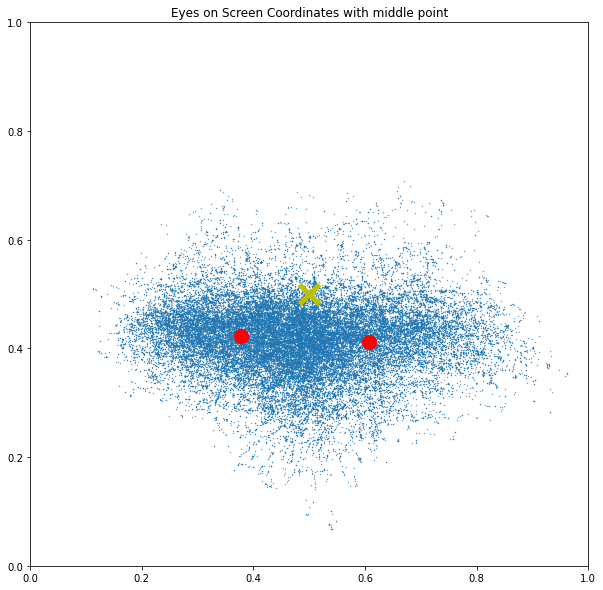

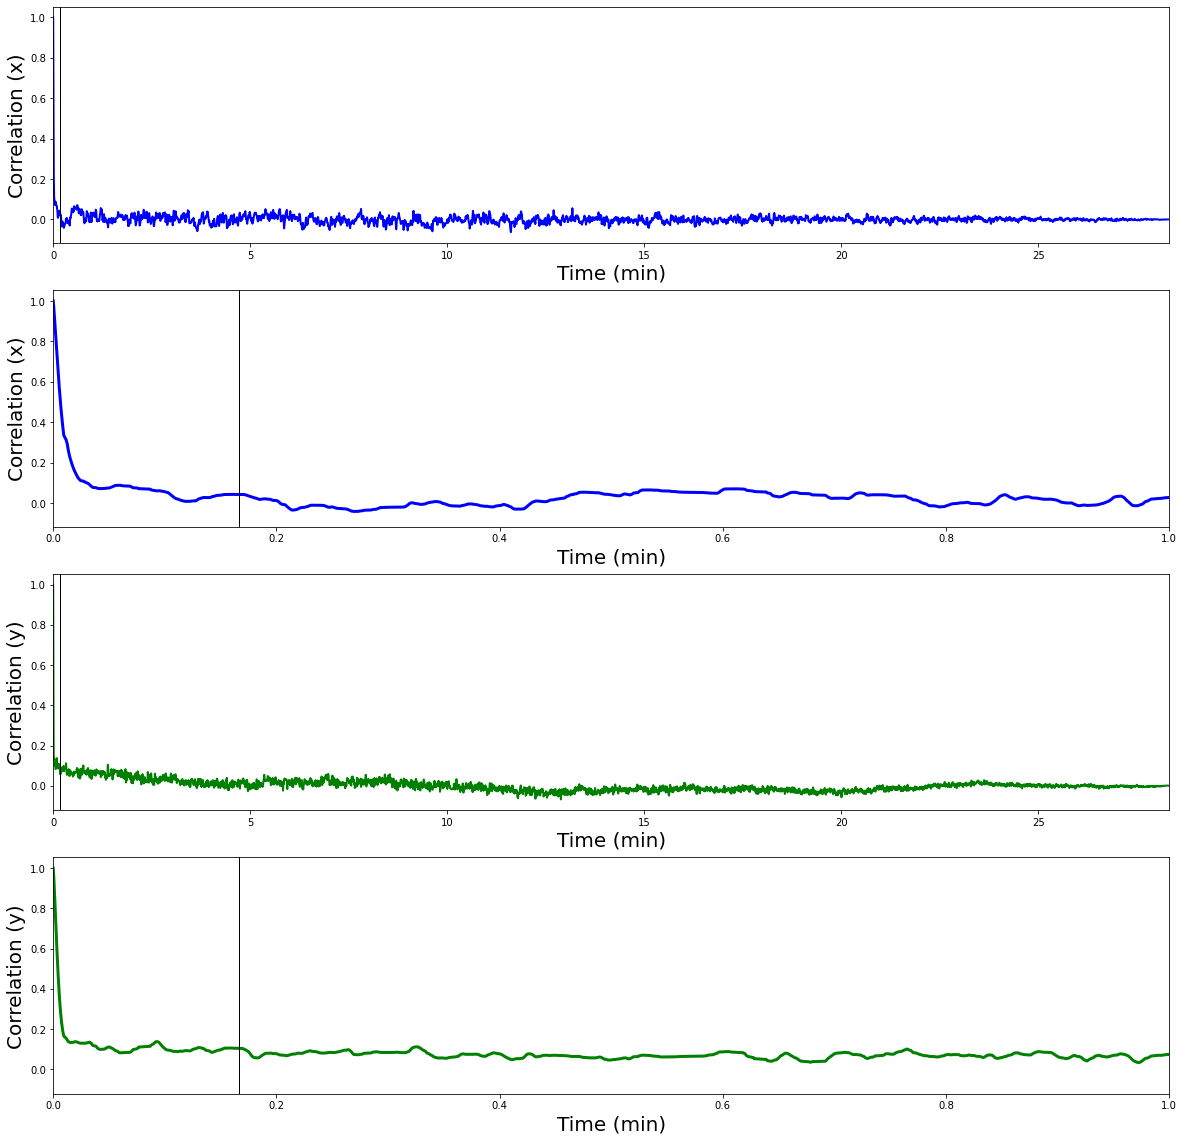

In [13]:
# set the subject ID that you want to analyse
subID = 7670

data = pd.read_csv(DATA_PATH + 'EyesOnScreen_VP' + str(subID) + '.txt', names=['X','Y']) 
data['X'] =  data['X'].apply(lambda x: x.replace('(','').replace(')','')) 
data['X'] = data['X'].astype('float')
data['Y'] =  data['Y'].apply(lambda x: x.replace('(','').replace(')','')) 
data['Y'] = data['Y'].astype('float')
data_OG_size = data.shape[0]


# only take coordinates in the interval [0,1[ (thereby also removing 0 entries)
data = data[(data.X>0) & (data.X<=1)]
data = data[(data.Y>0) & (data.Y<=1)]
data_processed_size = data.shape[0]

removedr = data_OG_size - data_processed_size
proportion = removedr/data_OG_size*100

print('VP{}: Removed rows outside interval: {} - Proportion: {}%'.format(subID, removedr, np.int(proportion)))

# normalising the vector coordinates to unit length (debug: only to check if the autocorrelation changes)
data_norm = pd.DataFrame(normalize([data.X,data.Y]).T, columns=['X','Y'])

# check if the normalised data is equal to the OG data
if (np.all(np.corrcoef(data.X, data_norm.X))) & (np.all(np.corrcoef(data.Y, data_norm.Y))):

    data['time'] = data.index*0.03/60.0

    autoc_X = acf(data['X'],nlags=len(data['X'])-1)
    autoc_Y = acf(data['Y'],nlags=len(data['Y'])-1)


    med_abs_X_10 = np.median(np.absolute(autoc_X[1:300]))
    max_abs_end = np.max(np.absolute(autoc_X[301::]))

    autocorr_data = pd.DataFrame()
    autocorr_data = autocorr_data.append({'Median Abs First Intervall': med_abs_X_10, 'Abs til end': max_abs_end}, ignore_index=True)


    # Some kmeans clustering on the Eye Position on screen
    data_clustering = data[['X','Y']].to_numpy()
    whitened = clusters.whiten(data_clustering)
    CL, distortion = clusters.kmeans(data_clustering, 2)
    avg_cluster_Y = CL[:,1]



    # -------------- PLOTTING --------------
    # first of all, plotting the coordinates on screen in a scatter plot
    plt.figure(figsize=(10,10))
    plt.title("Eyes on Screen Coordinates with middle point")
    plt.scatter(data_clustering[:, 0], data_clustering[:, 1], s=0.1)
    plt.scatter(0.5, 0.5, c='y', s=400, marker='x',linewidths=5)
    plt.scatter(CL[:, 0], CL[:, 1], c='r', s=200)
    plt.xlim([0,1])
    plt.ylim([0,1])

    if(autoc_X.size == autoc_Y.size):
        plt.figure(figsize=(20,20))

        # Subplot X corr x unlimited
        plt.subplot(4,1,1)
        plt.plot(data['time'],autoc_X,ls='-',c='b',linewidth=2)
        plt.xlabel('Time (min)',fontsize=20)
        plt.ylabel('Correlation (x)',fontsize=20)
        plt.xlim([0,np.max(data['time'])])
        # add a line at 10 second mark
        plt.axvline(x=0.1666666,c='k',linewidth=1)

        # Subplot X corr x limited
        plt.subplot(4,1,2)
        plt.plot(data['time'],autoc_X,ls='-',c='b',linewidth=3)
        plt.xlabel('Time (min)',fontsize=20)
        plt.ylabel('Correlation (x)',fontsize=20)
        plt.xlim([0,1])
        # add a line at 10 second mark
        plt.axvline(x=0.1666666,c='k',linewidth=1)

        # Subplot Y corr x unlimited
        plt.subplot(4,1,3)
        plt.plot(data['time'],autoc_Y,ls='-',c='g',linewidth=2)
        plt.xlabel('Time (min)',fontsize=20)
        plt.ylabel('Correlation (y)',fontsize=20)
        plt.xlim([0,np.max(data['time'])])
        # add a line at 10 second mark
        plt.axvline(x=0.1666666,c='k',linewidth=1)

        # Subplot Y corr x limited
        plt.subplot(4,1,4)
        plt.plot(data['time'],autoc_Y,ls='-',c='g',linewidth=3)
        plt.xlabel('Time (min)',fontsize=20)
        plt.ylabel('Correlation (y)',fontsize=20)
        plt.xlim([0,1])
        # add a line at 10 second mark
        plt.axvline(x=0.1666666,c='k',linewidth=1)
    else:
        print('The sizes of autocorrelation array do not match')